In [28]:
from matplotlib import pyplot as plt
import numpy as np
import os
import PIL.Image

import time
import torch, torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

import gradio as gr

In [29]:
#encontrando as pastas com as imagens
base_imagens = './data/raw'
pastas_doencas = os.listdir('./data/raw')
pastas_doencas

['ferrugem asiatica soja', 'mancha alvo soja', 'oídio soja']

In [30]:
#Criando a separação estratificada
quantidade_por_label = {pasta: len(os.listdir(os.path.join(base_imagens, pasta)))for pasta in pastas_doencas}

quantidade_por_label

{'ferrugem asiatica soja': 115, 'mancha alvo soja': 68, 'oídio soja': 51}

In [32]:
#criando as pastas de treino, validação e teste
imagens_processadas = ('./data/processed/')

dir_treino = os.path.join(imagens_processadas, 'treino')
dir_validacao = os.path.join(imagens_processadas, 'validacao')
dir_teste = os.path.join(imagens_processadas, 'teste')

if not os.path.exists(dir_treino):
    os.makedirs(dir_treino)
    
if not os.path.exists(dir_validacao):
    os.makedirs(dir_validacao)
    
if not os.path.exists(dir_teste):
    os.makedirs(dir_teste)

In [35]:
#criando as pastas de doenças(classe) para treino, validação e teste
#80% para o treino, 10% para validação e 10% para o teste
import shutil
from sklearn.model_selection import train_test_split

for classe in pastas_doencas:
    classe_treino = os.path.join(dir_treino, classe)
    classe_validacao = os.path.join(dir_validacao, classe)
    classe_teste = os.path.join(dir_teste, classe)
    
    if not os.path.exists(classe_treino):
        os.makedirs(classe_treino)
        
    if not os.path.exists(classe_validacao):
        os.makedirs(classe_validacao)
        
    if not os.path.exists(classe_teste):
        os.makedirs(classe_teste)
        
    pasta_classe = os.path.join(base_imagens, classe)
    
    arquivos_classe = os.listdir(pasta_classe)
    
    treino, valid_teste = train_test_split(arquivos_classe, shuffle=True, test_size=0.2, random_state=42)
    
    validacao, teste = train_test_split(valid_teste, shuffle=True, test_size=0.5, random_state= 42)
    
    del valid_teste
    
    print(f'{classe} - treino: {len(treino)} - valid: {len(validacao)} - teste: {len(teste)} - total: {len(arquivos_classe)}')
    
    for imagem_treino in treino:
        caminho_origem = os.path.join(base_imagens, classe, imagem_treino)
        caminho_destino = os.path.join(classe_treino, imagem_treino)
        
        shutil.copy(caminho_origem, caminho_destino)
        
    for imagem_validacao in validacao:
        caminho_origem = os.path.join(base_imagens, classe, imagem_validacao)
        caminho_destino = os.path.join(classe_validacao, imagem_validacao)
        
        shutil.copy(caminho_origem, caminho_destino)
        
    for imagem_teste in teste:
        caminho_origem = os.path.join(base_imagens, classe, imagem_teste)
        caminho_destino = os.path.join(classe_teste, imagem_teste)
        
        shutil.copy(caminho_origem, caminho_destino)

ferrugem asiatica soja - treino: 92 - valid: 11 - teste: 12 - total: 115
mancha alvo soja - treino: 54 - valid: 7 - teste: 7 - total: 68
oídio soja - treino: 40 - valid: 5 - teste: 6 - total: 51


In [39]:
#setando as cofigurações de imagens para os modelos
image_size = 100

transforms_imagens = {
    'treino': transforms.Compose([
        transforms.Resize(size=[image_size, image_size]), transforms.ToTensor(),
    ]),
    'validacao': transforms.Compose([
        transforms.Resize(size=[image_size, image_size]), transforms.ToTensor(),
    ]),
    'teste': transforms.Compose([
        transforms.Resize(size=[image_size, image_size]), transforms.ToTensor(),
    ]),
}

In [38]:
pasta_treino = dir_treino
pasta_validacao = dir_validacao
pasta_teste = dir_teste

In [40]:
#setando o tamanho do batch de treinamento
tamanho_batch = 8

numero_classes = len(os.listdir(pasta_treino))

numero_classes

3

In [43]:
#Carregando as imagens
data = {
    'treino': datasets.ImageFolder(root=pasta_treino, transform=transforms_imagens['treino']), 
    'validacao': datasets.ImageFolder(root=pasta_validacao, transform=transforms_imagens['validacao']),
}

data

{'treino': Dataset ImageFolder
     Number of datapoints: 186
     Root location: ./data/processed/treino
     StandardTransform
 Transform: Compose(
                Resize(size=[100, 100], interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ),
 'validacao': Dataset ImageFolder
     Number of datapoints: 23
     Root location: ./data/processed/validacao
     StandardTransform
 Transform: Compose(
                Resize(size=[100, 100], interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            )}

In [45]:
indice_classe = {indice: classe for classe, indice in data['treino'].class_to_idx.items()}

indice_classe

{0: 'ferrugem asiatica soja', 1: 'mancha alvo soja', 2: 'oídio soja'}

In [46]:
#quantidade de imagens para serem usadas nos cálculos de erro médio e acurácia
num_imagens_treino = len(data['treino'])
num_imagens_validacao = len(data['validacao'])

num_imagens_treino, num_imagens_validacao

(186, 23)

In [50]:
data_loader_treino = DataLoader (data['treino'], batch_size=tamanho_batch, shuffle=True)
data_loader_validacao = DataLoader (data['validacao'], batch_size=tamanho_batch, shuffle=True)

data_loader_treino, data_loader_validacao

(<torch.utils.data.dataloader.DataLoader at 0x2170828b3d0>,
 <torch.utils.data.dataloader.DataLoader at 0x217082a0890>)

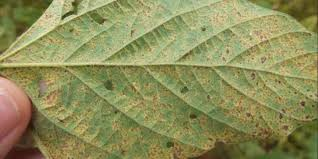

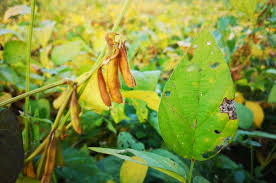

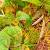

In [51]:
#mostrando algumas imagens para ver se está tudo certo
from IPython.display import Image

for classe in indice_classe.values():
    pasta_classe = os.path.join(pasta_treino, classe)
    arquivo_imagem = os.listdir(pasta_classe)[1]
    img = Image(filename=os.path.join(pasta_classe, arquivo_imagem))
    display(img)

In [52]:
#utilizando o alexnet, rede neural já pré treinada
alexnet = models.alexnet(pretrained=True)

alexnet

C:\Users\Jacqueline Nakagawa\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Jacqueline Nakagawa\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to C:\Users\Jacqueline Nakagawa/.cache\torch\hub\checkpoints\alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:28<00:00, 8.59MB/s] 


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [53]:
#congelando parâmetros
for param in alexnet.parameters():
    param.requires_grad = False

In [54]:
#alterando algumas configurações para melhor se adequar ao projeto
alexnet.classifier[6] = nn.Linear(4096, numero_classes)

alexnet.classifier.add_module("7", nn.LogSoftmax(dim = 1))

alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [55]:
parametros_ultima_camada = alexnet.classifier[6].parameters()

[parametro for parametro in parametros_ultima_camada][0].requires_grad

True

In [57]:
funcao_erro = nn.CrossEntropyLoss()

In [58]:
otimizador = optim.Adam(alexnet.parameters())
otimizador

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [85]:
#setando a função que vai treinar e validar
#cada época vai passar por todas as imagens, calculando os erros de treino e validação para o aprendizado da rede neural
def treinar_e_validar(modelo, metrica_erro, otimizador, epocas=10):
    historico = []
    melhor_acuracia = 0.0
    melhor_modelo = None
    acuracia_media_treino = 0.0
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    for epoca in range(epocas):
        inicio_epoca = time.time()
        print("\n\Época: {}/{}".format(epoca+1, epocas))
        
        erro_treino = 0.0
        acertos_treino = 0.0
        
        erro_validacao = 0.0
        acertos_validacao = 0.0
        
        for i, (imagens_lote, y_reais) in enumerate(data_loader_treino):
            imagens_lote = imagens_lote.to(device)
            y_reais = y_reais.to(device)
            
            otimizador.zero_grad()
            
            previsoes = modelo(imagens_lote)
 
            erro = metrica_erro(previsoes, y_reais)
            
            erro.backward()
            
            otimizador.step() 
            
            erro_treino += erro.item() * imagens_lote.size(0)
            
            _, classes_previstas = torch.max(previsoes.data, 1)
            predicoes_corretas = (classes_previstas == y_reais).type(torch.FloatTensor)
            
            acertos = torch.mean(predicoes_corretas)
            
            acertos_treino += torch.sum(predicoes_corretas)
            
        with torch.no_grad():
            modelo.eval()
                
            for j, (imagens_lote, y_reais) in enumerate(data_loader_validacao):
                imagens_lote = imagens_lote.to(device)
                y_reais = y_reais.to(device)
                
                previsoes = modelo(imagens_lote)
                
                erro = metrica_erro(previsoes, y_reais)
                
                erro_validacao += erro.item() * imagens_lote.size(0)
                
                _, classes_previstas = torch.max(previsoes.data, 1)
                predicoes_corretas = (classes_previstas == y_reais).type(torch.FloatTensor)
            
                acertos = torch.mean(predicoes_corretas)
            
                acertos_validacao += torch.sum(predicoes_corretas)
                
            erro_medio_treino = erro_treino/num_imagens_treino
            acuraria_media_treino = acertos_treino/num_imagens_treino
        
            erro_medio_validacao = erro_validacao/num_imagens_validacao
            acuracia_media_validacao = acertos_validacao/num_imagens_validacao
        
            historico.append([erro_medio_treino, erro_medio_validacao, acuracia_media_treino, acuracia_media_validacao])
        
            fim_epoca = time.time()
        
            print("Época: {:03d}, Treino: {:.4f}, Acurácia {:.4f}%, \n\t\tValidacao: Erro: {:.4f}, Acurácia: {:.4f}%, Tempo: {:.4f}s".format(epoca+1, erro_medio_treino, acuracia_media_treino*100, erro_medio_validacao, acuracia_media_validacao*100, fim_epoca-inicio_epoca))
        
            if acuracia_media_validacao > melhor_acuracia:
                melhor_acuracia = acuracia_media_validacao
                melhor_modelo = modelo
            
    return melhor_modelo, historico

In [86]:
indice_classe

{0: 'ferrugem asiatica soja', 1: 'mancha alvo soja', 2: 'oídio soja'}

In [87]:
#Vendo o resultado do treino
numero_epocas = 10

modelo_treinado, historico = treinar_e_validar(alexnet,funcao_erro,otimizador, numero_epocas)


\Época: 1/10
Época: 001, Treino: 0.0959, Acurácia 0.0000%, 
		Validacao: Erro: 2.2613, Acurácia: 21.7391%, Tempo: 1.3388s

\Época: 2/10
Época: 002, Treino: 0.1014, Acurácia 0.0000%, 
		Validacao: Erro: 2.5682, Acurácia: 21.7391%, Tempo: 1.3938s

\Época: 3/10
Época: 003, Treino: 0.1081, Acurácia 0.0000%, 
		Validacao: Erro: 2.2444, Acurácia: 17.3913%, Tempo: 1.3833s

\Época: 4/10
Época: 004, Treino: 0.0882, Acurácia 0.0000%, 
		Validacao: Erro: 2.3861, Acurácia: 21.7391%, Tempo: 1.4673s

\Época: 5/10
Época: 005, Treino: 0.0830, Acurácia 0.0000%, 
		Validacao: Erro: 2.2655, Acurácia: 39.1304%, Tempo: 1.3839s

\Época: 6/10
Época: 006, Treino: 0.0652, Acurácia 0.0000%, 
		Validacao: Erro: 2.5827, Acurácia: 21.7391%, Tempo: 1.3455s

\Época: 7/10
Época: 007, Treino: 0.1026, Acurácia 0.0000%, 
		Validacao: Erro: 2.4281, Acurácia: 21.7391%, Tempo: 1.3644s

\Época: 8/10
Época: 008, Treino: 0.0797, Acurácia 0.0000%, 
		Validacao: Erro: 2.3246, Acurácia: 30.4348%, Tempo: 1.4187s

\Época: 9/10
Ép

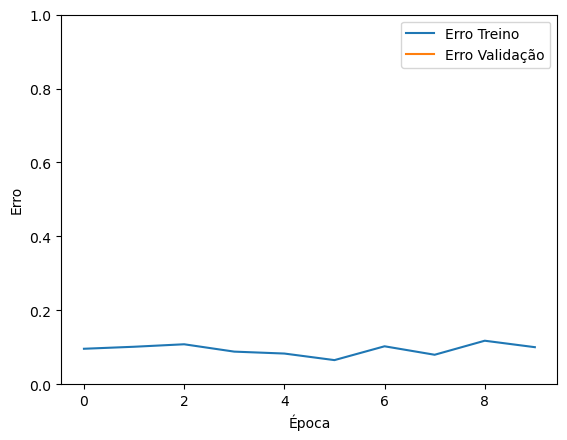

In [88]:
historico = np.array(historico)

plt.plot(historico[:,0:2])
plt.legend(['Erro Treino', 'Erro Validação'])
plt.xlabel('Época')
plt.ylabel('Erro')
plt.ylim(0,1)
plt.show()

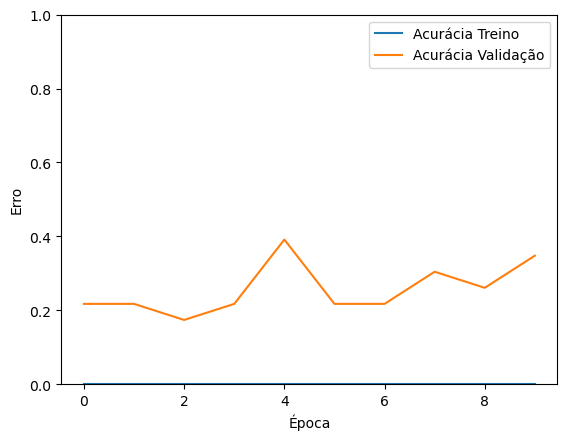

In [89]:
historico = np.array(historico)

plt.plot(historico[:,2:])
plt.legend(['Acurácia Treino', 'Acurácia Validação'])
plt.xlabel('Época')
plt.ylabel('Erro')
plt.ylim(0,1)
plt.show()

In [102]:
#criando função para prever classe de uma imagem  com o melhor modelo treinado
def predicao_doencas(imagem_teste):
    transformacao = transforms_imagens['teste']
    tensor_imagem_teste = transformacao(imagem_teste)
    
    if torch.cuda.is_available():
        tensor_imagem_teste = tensor_imagem_teste.view(1, 3, image_size, image_size).cuda()
    else:
        tensor_imagem_teste = tensor_imagem_teste.view(1, 3, image_size, image_size)
        
    dict_predicoes = dict()
    
    with torch.no_grad():
        modelo_treinado.eval()
        predicoes_log = modelo_treinado(tensor_imagem_teste)
        
        predicoes = torch.exp(predicoes_log)
        
        dict_predicoes = {indice_classe[classe]: float(predicoes[0][classe]) for classe in range(numero_classes)}
        
    return dict_predicoes

'ferrugem asiatica soja'

'ferrugem asiatica soja'

'oídio soja'

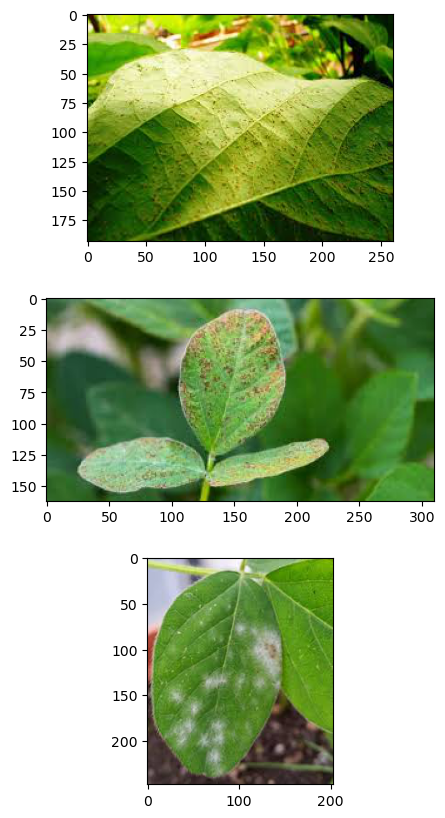

In [107]:
#realizando teste
figura, plots = plt.subplots(nrows=numero_classes, ncols=1, figsize=(5, 10))

for indice, classe in enumerate(pastas_doencas):
    pasta = os.path.join(pasta_teste, classe)
    imagem = os.path.join(pasta, os.listdir(pasta)[2])
    imagem_teste = PIL.Image.open(imagem)
    
    plots[indice].imshow(imagem_teste)
    
    predicoes = predicao_doencas(imagem_teste)
    
    display(max(predicoes, key=predicoes.get))

In [112]:
#criando função para verificar a acurácia dos testes
def acuracia_teste(pasta_teste):
    acertos = 0
    total_imagens = 0
    
    for classe in os.listdir(pasta_teste):
        pasta_completa = os.path.join(pasta_teste, classe)
        total_imagens += len(os.listdir(pasta_completa))
        
        for imagem in os.listdir(pasta_completa):
            imagem = os.path.join(pasta_completa, imagem)
            imagem_teste = PIL.Image.open(imagem)
            predicoes = predicao_doencas(imagem_teste)
            predicao = max(predicoes, key=predicoes.get)
            
            if predicao == classe:
                acertos += 1
                
    return 100 * acertos/total_imagens

In [120]:
acuracia_teste(pasta_teste)

60.0

In [ ]:
#Não foi possível implementar a biblioteca gradio, mas é uma das opções fáceis de se colocar o modelo em produção e começar os testes
interface_gradio = gr.Interface(fn=predicao_doencas,
                                 inputs=gr.inputs.Image(type="pil"),
                                 outputs="label").launch(share=True)